In [185]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np
df = pd.read_csv('covid.csv')
df

,country,region,region_code,start_date,end_date,days,year,week,population,total_deaths,covid_deaths,expected_deaths,excess_deaths,non_covid_deaths,covid_deaths_per_100k,excess_deaths_per_100k,excess_deaths_pct_change
0,Australia,Australia,0,2019-12-30,2020-01-05,7,2020,1,25921089,2926.0,0,2965.372893,-39.372893,2926.0,0.000000,-0.151895,-0.013278
1,Australia,Australia,0,2020-01-06,2020-01-12,7,2020,2,25921089,2902.0,0,2956.539560,-54.539560,2902.0,0.000000,-0.210406,-0.018447
2,Australia,Australia,0,2020-01-13,2020-01-19,7,2020,3,25921089,2914.0,0,2932.039560,-18.039560,2914.0,0.000000,-0.069594,-0.006153
3,Australia,Australia,0,2020-01-20,2020-01-26,7,2020,4,25921089,3007.0,0,2940.372893,66.627107,3007.0,0.000000,0.257038,0.022659
4,Australia,Australia,0,2020-01-27,2020-02-02,7,2020,5,25921089,2910.0,0,2900.039560,9.960440,2910.0,0.000000,0.038426,0.003435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5765,United States,United States,0,2022-05-09,2022-05-15,7,2022,19,336997624,57864.0,1868,55510.914407,2353.085593,55996.0,0.554307,0.698250,0.042390
5766,United States,United States,0,2022-05-16,2022-05-22,7,2022,20,336997624,57523.0,2461,54958.314407,2564.685593,55062.0,0.730272,0.761040,0.046666
5767,United States,United States,0,2022-05-23,2022-05-29,7,2022,21,336997624,56959.0,2607,54850.514407,2108.485593,54352.0,0.773596,0.625668,0.038441
5768,United States,United States,0,2022-05-30,2022-06-05,7,2022,22,336997624,57545.0,1956,54459.714407,3085.285593,55589.0,0.580420,0.915521,0.056653


In [189]:
df = df.dropna()
# Проверка монотонности индекса
if not df['start_date'].is_monotonic_increasing:
    df = df.sort_values(by='start_date')

In [179]:
print(df['region'].unique())

# Выбор региона с большим количеством данных, например США
selected_region = 'United States'
region_df = df[df['region'] == selected_region]

# Проверка на наличие данных для выбранного региона
if region_df.empty:
    raise ValueError(f"No data available for the selected region: {selected_region}")
covid_deaths_per_100k = region_df.set_index('start_date')['covid_deaths_per_100k']
print(covid_deaths_per_100k)

['Australia' 'Austria' 'Belgium' 'Britain' 'Bulgaria' 'Canada' 'Chile'
 'Colombia' 'Croatia' 'Cyprus' 'Czech Republic' 'Denmark' 'Ecuador'
 'Estonia' 'Finland' 'France' 'Germany' 'Greece' 'Guatemala' 'Hungary'
 'Iceland' 'Iran' 'Israel' 'Italy' 'Latvia' 'Lithuania' 'Luxembourg'
 'Malta' 'Mexico' 'Montenegro' 'Netherlands' 'New Zealand' 'Norway' 'Peru'
 'Poland' 'Portugal' 'Romania' 'Slovakia' 'Slovenia' 'South Africa'
 'South Korea' 'Spain' 'Sweden' 'Switzerland' 'Tunisia' 'United States']
start_date
2019-12-30    0.000000
2020-01-06    0.000000
2020-01-13    0.000000
2020-01-20    0.000000
2020-01-27    0.000000
                ...   
2022-05-09    0.554307
2022-05-16    0.730272
2022-05-23    0.773596
2022-05-30    0.580420
2022-06-06    0.821964
Name: covid_deaths_per_100k, Length: 128, dtype: float64


In [197]:
covid_deaths_per_100k = region_df.set_index('start_date')['covid_deaths_per_100k']

# Приведение ряда к недельному интервалу
covid_deaths_per_100k = covid_deaths_per_100k.resample('W').mean()

result = adfuller(covid_deaths_per_100k)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

if result[1] > 0.05:
    covid_deaths_per_100k_stationary = covid_deaths_per_100k.diff().dropna()
else:
    covid_deaths_per_100k_stationary = covid_deaths_per_100k

ADF Statistic: -3.587987363510501
p-value: 0.005994880308406632


In [198]:
train_size = int(len(covid_deaths_per_100k_stationary) * 0.8)
train, test = covid_deaths_per_100k_stationary[:train_size], covid_deaths_per_100k_stationary[train_size:]

# Обучение модели Arima на обучающей выборке
model = pm.auto_arima(train, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
print(model.summary())

# Прогнозирование на тестовой выборке
forecast, conf_int = model.predict(n_periods=len(test), return_conf_int=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=161.634, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=507.766, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=168.561, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=392.044, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=162.960, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=159.998, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=163.859, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=161.414, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=161.589, Time=0.07 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=160.439, Time=0.04 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=162.372, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=154.475, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=163.086, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=159.872, Time=0.07 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=159.3

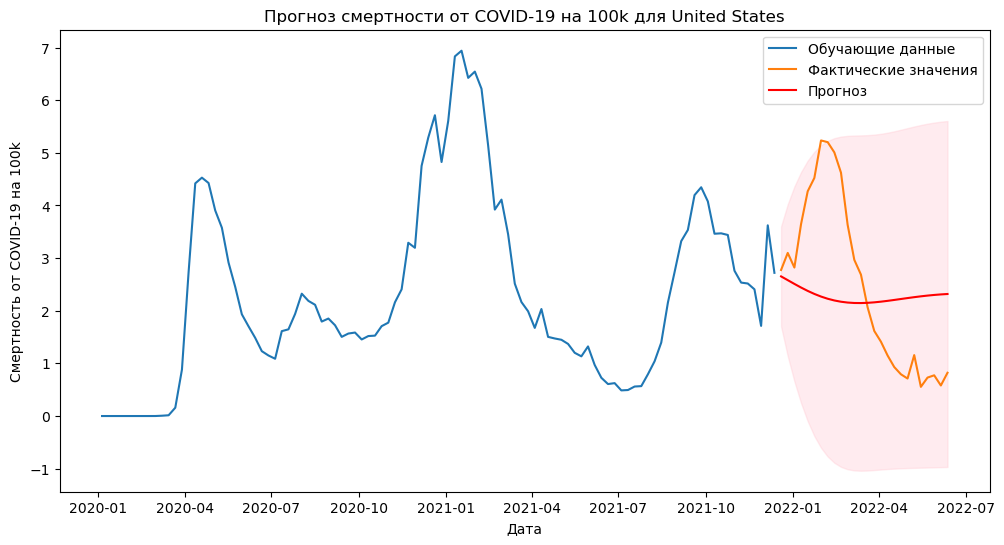

In [199]:
plt.figure(figsize=(12, 6))
plt.plot(train, label='Обучающие данные')
plt.plot(test.index, test, label='Фактические значения')
plt.plot(test.index, forecast, label='Прогноз', color='red')
plt.fill_between(test.index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.title(f'Прогноз смертности от COVID-19 на 100k для {selected_region}')
plt.xlabel('Дата')
plt.ylabel('Смертность от COVID-19 на 100k')
plt.show()

In [200]:
r2_arima = r2_score(test, forecast)
print(f'R2 Score for ARIMA on Test Data: {r2_arima}')

# Кросс-валидация для модели ARIMA
tscv = TimeSeriesSplit(n_splits=5)
arima_scores = []

for train_index, test_index in tscv.split(covid_deaths_per_100k_stationary):
    train_cv, test_cv = covid_deaths_per_100k_stationary[train_index], covid_deaths_per_100k_stationary[test_index]
    model_cv = pm.auto_arima(train_cv, seasonal=False, trace=False, error_action='ignore', suppress_warnings=True)
    forecast_cv = model_cv.predict(n_periods=len(test_cv))
    arima_scores.append(r2_score(test_cv, forecast_cv))

print(f'Cross-Validation Arima: {arima_scores}')
print(f'Mean Cross-Validation Arima: {np.mean(arima_scores)}')

R2 Score for ARIMA on Test Data: -0.0031657138589544775


D:\Users\aomurbaeva\AppData\Local\Temp\ipykernel_4800\2264754552.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, test_cv = covid_deaths_per_100k_stationary[train_index], covid_deaths_per_100k_stationary[test_index]
D:\Users\aomurbaeva\AppData\Local\Temp\ipykernel_4800\2264754552.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, test_cv = covid_deaths_per_100k_stationary[train_index], covid_deaths_per_100k_stationary[test_index]
D:\Users\aomurbaeva\AppData\Local\Temp\ipykernel_4800\2264754552.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version

Cross-Validation Arima: [-0.406087043227352, -3.1984039886431814, -2.1947987623668186, -0.7659440050702266, 0.5890588838417696]
Mean Cross-Validation Arima: -1.1952349830931617


График показывает, что прогнозы модели arima не совпадают с фактическими значениями
Возможно данные о смертности от covid 19 могут иметь много шума, что затрудняет их моделирование с помощью arima
Возможно данные недостаточно стационарны
Так же возможно arima не подходит для данных этого датасета